# Train a Plane Detection Model from Voxel51 Dataset
This notebook trains a plane detection model using transfer learning. 
Depending on the label used, it can just detect a plane or it can try to detect the model of the plane.
A pre-trained model is used as a starting point. This means that fewer example images are needed and the training process is faster.

Images are exported from a Voxel51 Dataset into TensorFlow Records.The examples in the TFRecord are based on a selected Field from the Samples in the Voxel51 dataset. The V51 Sample field you choose should have 1 or more "detections", which are bounding boxes with a label.

From: https://colab.research.google.com/drive/1sLqFKVV94wm-lglFq_0kGo2ciM0kecWD#scrollTo=wHfsJ5nWLWh9&uniqifier=1

Good stuff here too: https://www.inovex.de/blog/deep-learning-mobile-tensorflow-lite/ 

## Configure the Training

In [7]:
training_name="mobilenet_plane_detect" # The name for the model. All of the different directories will be based on this
label_field = "planebox"  # The field from the V51 Samples around which will be used for the Labels for training.
dataset_name = "plane-dataset" # The name of the V51 dataset that will be used


# Available Model Configs (You can add more from the TF2 Model Zoo)
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
        'batch_size': 24
    },
    'ssd_mobilenet_v2_fpnlite': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz',
        'batch_size': 18
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 18
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 18
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 18
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 18
    }
}

# change chosen model to deploy different models 
chosen_model = 'ssd_mobilenet_v2'#'efficientdet-d0'

num_steps = 40000 # The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 # Perform evaluation after so many steps



In [2]:
# The different directories and filenames to use
train_record_fname = "/tf/dataset-export/" + training_name + "/train/tf.records"
val_record_fname = "/tf/dataset-export/" + training_name + "/val/tf.records"
val_export_dir = "/tf/dataset-export/" + training_name + "/val/"
train_export_dir = "/tf/dataset-export/" + training_name + "/train/"
model_export_dir = "/tf/model-export/" + training_name +"/"

label_map_file = "/tf/dataset-export/" + training_name + "/label_map.pbtxt"

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

pipeline_fname = '/tf/models/research/deploy/' + base_pipeline_file
fine_tune_checkpoint = '/tf/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'
pipeline_file = '/tf/models/research/deploy/pipeline_file.config'
model_dir = '/tf/training/'+training_name+'/'

In [3]:
# Install the different packages needed
! apt install -y protobuf-compiler libgl1-mesa-glx wget

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
wget is already the newest version (1.19.4-1ubuntu2.2).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


## Download and Install TF Models
The TF Object Detection API is available here: https://github.com/tensorflow/models

In [3]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models /tf/models

In [6]:
%%bash
cd /tf/models/research
ls
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

README.md
a3c_blogpost
adversarial_text
attention_ocr
audioset
autoaugment
cognitive_planning
cvt_text
deep_speech
deeplab
delf
deploy
efficient-hrl
lfads
lstm_object_detection
marco
nst_blogpost
object_detection
pcl_rl
rebar
seq_flow_lite
setup.py
slim
vid2depth
Processing /tf/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1617398 sha256=149ca6b465c94f1a4f28df6e651038fb7c864fd52dca96b67a531ce3a76e9791
  Stored in directory: /tmp/pip-ephem-wheel-cache-a2dkztuf/wheels/1b/00/50/d3675d90b11a88efdd99ed80b60a2b19e5769a0bb333440375
  Created wheel for avro-python3: filename=avro_python3-1.10.1-py3-none-any.whl size=43735 sha256=7b29bd6739689db6066c7c6d16ad8c08fd4ab83475028e6c3ac1aff274998a64
  Stored in directory: /root/.cache/pip/wheels/e5/61/57/c8a8c1d1155f720f2bf7182c25b0937303698c6693aee22b55
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp36-cp36m-linux_x86_64.whl size=265633 sha256=fa9d1181d1a26c431f7ef611b4aeb0b1

bash: line 3: protoc: command not found
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tf-nightly 2.5.0.dev20210203 requires gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
tf-nightly 2.5.0.dev20210203 requires h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
apache-beam 2.27.0 requires avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.
tensorflow 2.4.1 requires grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
tensorflow-metadata 0.27.0 requires absl-py<0.11,>=0.9, but you'll have absl-py 0.11.0 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [10]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf
from object_detection.protos.string_int_label_map_pb2 import StringIntLabelMap, StringIntLabelMapItem
from google.protobuf import text_format
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## Export the Training and Val Dataset from Voxel 51

In [8]:
import fiftyone as fo
import math
dataset = fo.load_dataset(dataset_name)


### Explore the dataset content
Here are some basic stats on the Voxel51 dataset you are going to build training the model on. 
An example of the samples is also printed out. In the Sample, make sure the *label_field* you selected has some detections in it.

In [5]:
print("\t\tDataset\n-----------------------------------")
view = dataset.exists(label_field).shuffle(seed=51) # You can add additional things to the query to further refine it. eg .match_tags("good_box")
print(view)
print("\n\n\tExample Sample\n-----------------------------------")
print(view.first())


		Dataset
-----------------------------------
Dataset:        plane-dataset
Media type:     image
Num samples:    11276
Tags:           ['good_box', 'plane']
Sample fields:
    filepath:      fiftyone.core.fields.StringField
    tags:          fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    icao24:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    plane:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    plane_spot:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    labelbox_id:   fiftyone.core.fields.StringField
    plane-box:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    plane_box:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    planebox:      fiftyone.core.fields.EmbeddedDocumentField

### Export the dataset into TFRecords
The selected dataset samples will be exported to TensorFlow Records (TFRecords). They will be split between Training and Validation. The ratio can be adjusted below. You only need to do this once to build the dataset. If you run this a second time with the same **model_name** additional samples will be appended to the end.

In [ ]:
# The Dataset or DatasetView to export
sample_len = len(view)
val_len = math.floor(sample_len * 0.2)
train_len = math.floor(sample_len * 0.8)
print("Total: {} Val: {} Train: {}".format(sample_len,val_len,train_len))
val_view = view.take(val_len)
train_view = view.skip(val_len).take(train_len)
# Export the dataset
val_view.export(
    export_dir=val_export_dir,
    dataset_type=fo.types.TFObjectDetectionDataset,#fo.types.COCODetectionDataset,#fo.types.TFObjectDetectionDataset,
    label_field=label_field,
)

train_view.export(
    export_dir=train_export_dir,
    dataset_type=fo.types.TFObjectDetectionDataset,#fo.types.COCODetectionDataset,#fo.types.TFObjectDetectionDataset,
    label_field=label_field,
)

## Create a file with the Labels for the objects
The TF2 Object Detection API looks for a map of the labels used and a corresponding Id. You can build a list of the unique classnames by itterating the dataset. You can also just hardcode it if there only a few.

In [2]:
def convert_classes(classes, start=1):
    msg = StringIntLabelMap()
    for id, name in enumerate(classes, start=start):
        msg.item.append(StringIntLabelMapItem(id=id, name=name))

    text = str(text_format.MessageToBytes(msg, as_utf8=True), 'utf-8')
    return text

In [12]:
# If labelfield is a classification
class_names=[]
for sample in view.select_fields(label_field):
    if sample[label_field].label not in class_names:
        class_names.append(sample[label_field].label)
print(class_names)

AttributeError: 'Detections' object has no attribute 'label'

In [7]:
# If labelfield is detections
class_names=[]
for sample in view.select_fields(label_field):
    for detection in sample[label_field].detections:
        label = detection["label"]
        if label not in class_names:
            class_names.append(label)
print(class_names)

['ERJ-170', '737-700', 'EMB-135', 'A321', 'A320', 'Bombardier Challanger', '737-800', 'Cirrus', 'Hawker', 'Cessna Jet', 'EMB-505', 'Lancair IV', '757-200', 'CRJ900', '737-900', 'Falcon', 'A319', 'CRJ700', 'Gulfstream', 'Learjet 45/60', 'CRJ550', 'A330', '767-300', 'King Air', '787-800', 'Pilatus PC-12', '777-200', 'Piper PA-23']


In [3]:
# You can hard wire it too
class_names=["plane"]

In [7]:

txt = convert_classes(class_names)
print(txt)
with open(label_map_file, 'w') as f:
        f.write(txt)

item {
  name: "plane"
  id: 1
}



## Download a pretrained Model & default Config
A list of the models can be found here: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

The configs are here: https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/

In [13]:
#download pretrained weights
%mkdir /tf/models/research/deploy/
%cd /tf/models/research/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

mkdir: cannot create directory ‘/tf/models/research/deploy/’: File exists
/tf/models/research/deploy
--2021-02-04 18:33:22--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.73.208, 2607:f8b0:4004:829::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.73.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46042990 (44M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz.1’

ssd_mobilenet_v2_32 100%[===================>]  43.91M  85.0MB/s    in 0.5s    

2021-02-04 18:33:22 (85.0 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz.1’ saved [46042990/46042990]



In [14]:
#download base training configuration file
%cd /tf/models/research/deploy
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

/tf/models/research/deploy
--2021-02-04 18:33:27--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_mobilenet_v2_320x320_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4484 (4.4K) [text/plain]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.config.2’

ssd_mobilenet_v2_32 100%[===================>]   4.38K  --.-KB/s    in 0s      

2021-02-04 18:33:27 (29.2 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.config.2’ saved [4484/4484]



In [13]:
!python /tf/models/research/object_detection/dataset_tools/create_pet_tf_record.py \
    --label_map_path="/tf/dataset-export/pet/pet_label_map.pbtxt" \
    --data_dir="/tf/dataset-export/pet/" \
    --output_dir="/tf/dataset-export/pet/"

2021-02-04 20:57:53.688423: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0204 20:57:56.316582 140174250731328 create_pet_tf_record.py:273] Reading from Pet dataset.
I0204 20:57:56.318240 140174250731328 create_pet_tf_record.py:288] 140 training and 60 validation examples.
I0204 20:57:56.318891 140174250731328 create_pet_tf_record.py:241] On image 0 of 140
/usr/local/lib/python3.6/dist-packages/object_detection/utils/dataset_util.py:83: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:
I0204 20:57:56.587526 140174250731328 create_pet_tf_record.py:241] On image 100 of 140
W0204 20:57:56.590239 140174250731328 create_pet_tf_record.py:246] Could not find /tf/dataset-export/pet/annotations/xmls/Abyssinian_104.xml, ignoring example.
I0204 20:57:56.698127 140174250731328 create_pet_tf_record.py:241] On image 0 of 60


## Build the Config for training
The default config for the model being trained needs to be updated with the correct parameters and paths to the data. This just adds some standard settings, you may need to do some additional tuning if the training is not working well.

In [1]:
# Gets the total number of classes from the Label Map

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_file)
print("working with {} classes".format(num_classes))

NameError: name 'label_map_file' is not defined

You may need to adjust the learning rate section below. The number used here are from the EfficentDet config. I noticed that this learning rate worked well for the small bounding boxes I was using when planes were at a high altitude. You can try increasing it if the planes take up more of the image. If the initial loss rates are high (>0) that is a probably a sign that you should adjust the Learning Rate.

You may also want to look at other aspects of the config file. They set the parameters for the model training and may need to be adjusted based on the Model Architecture you are using and the images you are training on.

In [19]:
# write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file

import re

%cd /tf/models/research/deploy
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_file), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set learning_rate_base in learning_rate, sane default
    s = re.sub('learning_rate_base: [.0-9]+',
               'learning_rate_base: {}'.format("8e-2"), s)
    
    # Set warmup_learning_rate in learning_rate, sane default
    s = re.sub('warmup_learning_rate: [.0-9]+',
               'warmup_learning_rate: {}'.format(.001), s)
    
    # Set warmup_steps in learning_rate, sane default
    s = re.sub('warmup_steps: [.0-9]+',
               'warmup_steps: {}'.format(2500), s)
    
    # Set total_steps in learning_rate, num_steps
    s = re.sub('total_steps: [0-9]+',
               'total_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)

/tf/models/research/deploy
writing custom configuration file


In [20]:
%cat /tf/models/research/deploy/pipeline_file.config

# SSD with Mobilenet v2
# Trained on COCO17, initialized from Imagenet classification checkpoint
# Train on TPU-8
#
# Achieves 22.2 mAP on COCO17 Val

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
 

# Train Custom TF2 Object Detector

This step will launch the TF2 Object Detection training. It can take a while to start-up. 
If you get an error about not finding the GPU, try shutting down the Jupyter kernel and restarting it.
While it is running, it should print out the Current Loss and which Step it is on.

* pipeline_file: defined above in writing custom training configuration
* model_dir: the location tensorboard logs and saved model checkpoints will save to
* num_train_steps: how long to train for
* num_eval_steps: perform eval on validation set after this many steps

In [ ]:
!python /tf/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps} 

2021-02-05 00:45:53.181150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-02-05 00:45:57.112927: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-05 00:45:57.113918: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-05 00:45:57.138294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-02-05 00:45:57.140275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:08:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0205 00:46:12.506033 140004914661184 deprecation.py:339] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
W0205 00:46:18.808966 140004914661184 deprecation.py:339] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Use `tf.cast` instead.
W0205 00:46:22.570807 14000491

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0205 00:47:29.082173 140004914661184 cross_device_ops.py:565] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0205 00:47:29.084899 140004914661184 cross_device_ops.py:565] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0205 00:47:29.087792 140004914661184 cross_device_ops.py:565] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Red

# Evaluate trained model
After the model has finished training, try running it against some data to see if it atleast works.

In [7]:

import matplotlib
import matplotlib.pyplot as plt

import io, os, glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [8]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [6]:
%ls {model_dir}

checkpoint                   ckpt-38.index
ckpt-35.data-00000-of-00001  ckpt-39.data-00000-of-00001
ckpt-35.index                ckpt-39.index
ckpt-36.data-00000-of-00001  ckpt-40.data-00000-of-00001
ckpt-36.index                ckpt-40.index
ckpt-37.data-00000-of-00001  ckpt-41.data-00000-of-00001
ckpt-37.index                ckpt-41.index
ckpt-38.data-00000-of-00001  train/


## Load model from a training checkpoint
Select a checkpoint index from above

In [9]:
# generally you want to put the last ckpt index from training in here
checkpoint_index=41

# recover our saved model
pipeline_config = pipeline_file

checkpoint = model_dir + "ckpt-" + str(checkpoint_index)
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(checkpoint)).expect_partial()


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [10]:
# map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
tf.Tensor(
[[0.9557309  0.01890148 0.01858725 0.0149516  0.01485214 0.01444705
  0.01392569 0.01345286 0.0133953  0.01195482 0.01189219 0.01151443
  0.01145964 0.01117153 0.0111433  0.01094049 0.01084022 0.01079016
  0.01066084 0.0105661  0.01026059 0.01020276 0.00999093 0.00971778
  0.00970752 0.00939484 0.00910211 0.00909745 0.0089463  0.00887948
  0.00886098 0.00858613 0.00816966 0.0081567  0.0080395  0.00787827
  0.00766625 0.00753622 0.00752332 0.00740617 0.00737756 0.00736515
  0.00717283 0.00711066 0.00692414 0.00688566 0.00683934 0.00682285
  0.00675159 0.00673726 0.00672844 0.00651434 0.0064758

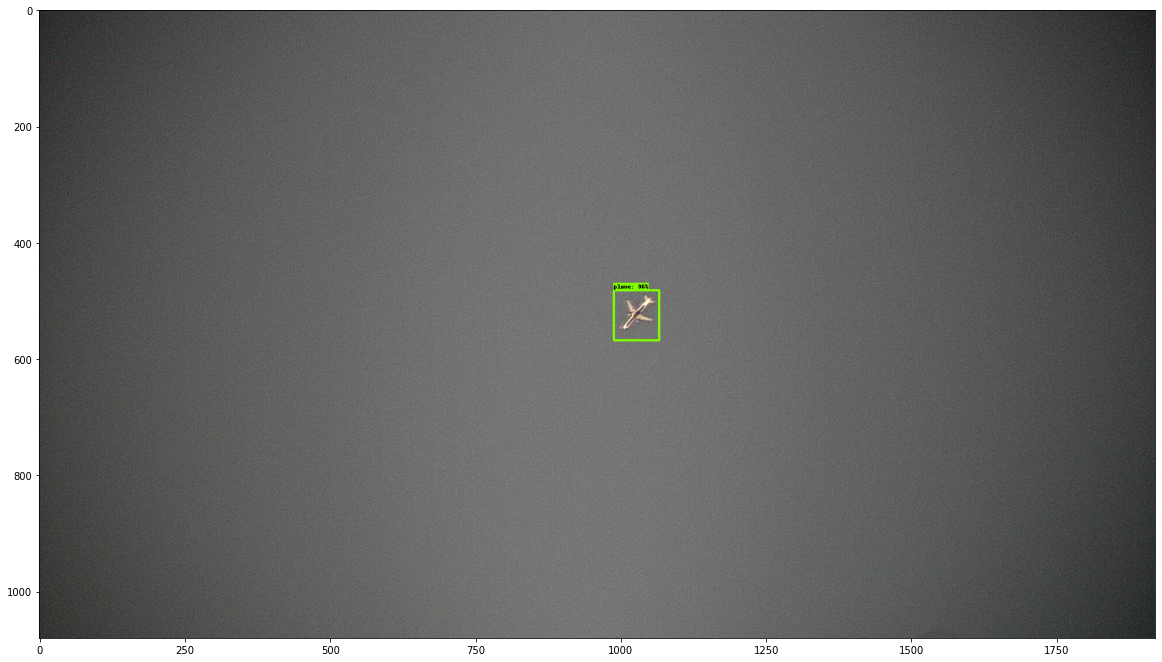

In [11]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

TEST_IMAGE_PATHS = glob.glob('/tf/testing/Airbus A321-271NX/*.jpg') #/tf/dataset-export/pet/images/keeshond_171.jpg') #'/tf/testing/Dassault Aviation FALCON 2000/*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

detections, predictions_dict, shapes = detect_fn(input_tensor)


print(detections['detection_scores'])
label_id_offset = 1 # Depending on whether your LabelMap starts at 0 or 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.2,
      agnostic_mode=False,
)

plt.figure(figsize=(20,25))
plt.imshow(image_np_with_detections)
plt.show()

# Export the model
When you have a working model, use the TF2 Object Detection API to export it to a saved model.

In [28]:
!python /tf/models/research/object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --trained_checkpoint_dir={model_dir} \
    --pipeline_config_path={pipeline_file} \
    --output_directory {model_export_dir}

2021-02-05 22:43:20.940158: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-02-05 22:43:24.427809: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-05 22:43:24.428793: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-05 22:43:24.448454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-02-05 22:43:24.450131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:08:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-

W0205 22:43:50.455373 140428151187264 save_impl.py:78] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7fb5b419b908>, because it is not built.
2021-02-05 22:44:05.012020: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
W0205 22:44:25.234425 140428151187264 save.py:241] Found untraced functions such as BoxPredictor_layer_call_and_return_conditional_losses, BoxPredictor_layer_call_fn, BoxPredictor_layer_call_fn, BoxPredictor_layer_call_and_return_conditional_losses, BoxPredictor_layer_call_and_return_conditional_losses while saving (showing 5 of 125). These functions will not be directly callable after loading.
W0205 22:44:27.008607 140428151187264 save.py:241] Found untraced functions such as BoxPredictor_layer_call_and_return_conditional_losses, BoxPredictor_layer_call_fn, BoxPredictor_layer_call_fn, BoxPredictor_la

### Export a TFLite compatible model

In [31]:
!python /tf/models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path={pipeline_file} \
  --trained_checkpoint_dir={model_dir} \
  --output_directory={model_export_dir}tflite-compatible


2021-02-05 22:52:08.470628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-02-05 22:52:11.871046: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-05 22:52:11.872127: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-05 22:52:11.895154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-02-05 22:52:11.896992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:08:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-

2021-02-05 22:52:24.044118: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-02-05 22:52:24.067324: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199960000 Hz
2021-02-05 22:52:26.038604: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-05 22:52:26.039462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-02-05 22:52:26.040464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:08:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-02-05 22

W0205 22:53:01.574485 140650094450496 save.py:241] Found untraced functions such as BoxPredictor_layer_call_fn, BoxPredictor_layer_call_and_return_conditional_losses, BoxPredictor_layer_call_fn, BoxPredictor_layer_call_and_return_conditional_losses, BoxPredictor_layer_call_and_return_conditional_losses while saving (showing 5 of 125). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /tf/model-export/mobilenet_plane_detect/tflite-compatible/saved_model/assets
I0205 22:53:08.692620 140650094450496 builder_impl.py:775] Assets written to: /tf/model-export/mobilenet_plane_detect/tflite-compatible/saved_model/assets


In [25]:
! tflite_convert \
    --saved_model_dir="{model_export_dir}tflite/saved_model" \
    --output_file="{model_export_dir}output.tflite"

2021-02-05 22:07:27.636469: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-02-05 22:07:31.187904: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-05 22:07:31.189009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-05 22:07:31.211942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-02-05 22:07:31.213829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:08:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-

2021-02-05 22:07:49.264710: I tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-02-05 22:07:49.322327: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199960000 Hz
2021-02-05 22:07:49.950484: I tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /tf/model-export/mobilenet_plane_detect/tflite/saved_model
2021-02-05 22:07:50.227594: I tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 1498846 microseconds.
2021-02-05 22:07:51.593605: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:194] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-02-05 22:07:52.406490: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-05 22:07:52.408826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciB

In [35]:
#https://github.com/tensorflow/models/issues/9033#issuecomment-706573546
import cv2
import glob
import numpy as np

train_images = []

def representative_data_gen():
    path = '/tf/testing/Airbus A319-115'

    dataset_list = tf.data.Dataset.list_files(path + '/*.jpg')
    for i in range(100):
        image = next(iter(dataset_list))
        image = tf.io.read_file(image)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [300, 300])
        image = tf.cast(image / 255., tf.float32)
        image = tf.expand_dims(image, 0)
        yield [image]


converter = tf.lite.TFLiteConverter.from_saved_model(model_export_dir+"tflite-compatible/saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
                                       tf.lite.OpsSet.TFLITE_BUILTINS]
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

# Save the model.
with open(model_export_dir+'model.tflite', 'wb') as f:
  f.write(tflite_model)

ConverterError: <unknown>:0: error: loc(callsite(callsite("map/TensorArrayV2_1@__inference_call_func_9794" at "StatefulPartitionedCall@__inference_signature_wrapper_11778") at "StatefulPartitionedCall")): requires element_shape to be 1D tensor during TF Lite transformation pass
<unknown>:0: note: loc("StatefulPartitionedCall"): called from
<unknown>:0: error: loc(callsite(callsite("map/TensorArrayV2_1@__inference_call_func_9794" at "StatefulPartitionedCall@__inference_signature_wrapper_11778") at "StatefulPartitionedCall")): failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc("StatefulPartitionedCall"): called from


In [19]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | tee /etc/apt/sources.list.d/coral-edgetpu.list
!apt-get update
!apt-get -y install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1974  100  1974    0     0  34631      0 --:--:-- --:--:-- --:--:-- 34631
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6722 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:5 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages [2172 B]
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_

In [32]:
!edgetpu_compiler -s {model_export_dir}model.tflite -o {model_export_dir}

Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 1693 ms.

Input model: /tf/model-export/mobilenet_plane_detect/model.tflite
Input size: 5.08MiB
Output model: /tf/model-export/mobilenet_plane_detect/model_edgetpu.tflite
Output size: 5.28MiB
On-chip memory used for caching model parameters: 5.16MiB
On-chip memory remaining for caching model parameters: 2.56MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 112
Operation log: /tf/model-export/mobilenet_plane_detect/model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 108
Number of operations that will run on CPU: 4

Operator              

### Export a TensorJS compatible model
From: https://www.tensorflow.org/js/tutorials/conversion/import_saved_model

In [14]:
!pip install tensorflowjs

     |████████████████████████████████| 63 kB 1.2 MB/s  eta 0:00:01
     |████████████████████████████████| 103 kB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 17.5 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tf-nightly 2.5.0.dev20210203 requires gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
tf-nightly 2.5.0.dev20210203 requires grpcio~=1.34.0, bu

In [17]:
! tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='Postprocessor/ExpandDims_1,Postprocessor/Slice'  \
    --saved_model_tags=serve \
    {model_export_dir}saved_model \
    {model_export_dir}web_model

2021-02-05 21:50:06.889060: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-02-05 21:50:10.038179: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-05 21:50:10.039279: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-05 21:50:10.062587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-02-05 21:50:10.064421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:08:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-

2021-02-05 21:50:25.173512: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 2283 nodes (1953), 4041 edges (3708), time = 94.243ms.
  function_optimizer: function_optimizer did nothing. time = 1.717ms.

2021-02-05 21:50:26.989479: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  debug_stripper: Graph size after: 1046 nodes (0), 2346 edges (0), time = 1.089ms.
  model_pruner: Graph size after: 707 nodes (-339), 2007 edges (-339), time = 10.901ms.
  constant_folding: Graph size after: 334 nodes (-373), 1632 edges (-375), time = 67.806ms.
  arithmetic_optimizer: Graph size after: 334 nodes (0), 1632 edges (0), time = 15.97ms.
  dependency_optimizer: Graph size after: 5 nodes (-329), 0 edges (-1632), time = 22.904ms.
  model_pruner: Graph size after: 5 nodes (0), 0 edges (0), time = 0.804ms.
  constant_folding: